<a href="https://colab.research.google.com/github/MattFinney/practical_data_science_in_python/blob/main/Session_2_Practical_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/><a>

# Practical Data Science in Python
## Unsupervised Learning: Classifying Spotify Tracks by Genre with $k$-Means Clustering
Authors: Matthew Finney, Paulina Toro Isaza


#### Run this First! (Function Definitions)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set1')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import Audio, Image, clear_output
rs = 123
np.random.seed(rs)

def pca_plot(df, classes=None):

    # Scale data for PCA
    scaled_df = StandardScaler().fit_transform(df)
    
    # Fit the PCA and extract the first two components
    pca_results = PCA().fit_transform(scaled_df)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]
    
    # Sort the legend labels
    if classes is None:
      hue_order = None
      n_classes = 0
    elif str(classes[0]).isnumeric():
      classes = ['Cluster {}'.format(x) for x in classes]
      hue_order = sorted(np.unique(classes))
      n_classes = np.max(np.unique(classes).shape)
    else:
      hue_order = sorted(np.unique(classes))
      n_classes = np.max(np.unique(classes).shape)

    # Plot the first two principal components
    plt.figure(figsize=(8.5,8.5))
    plt.grid()
    sns.scatterplot(pca1_scores, pca2_scores, s=50, hue=classes,
                    hue_order=hue_order, palette='Set1')
    plt.xlabel("Principal Component {}".format(1))
    plt.ylabel("Principal Component {}".format(2))
    plt.title('Principal Component Plot')
    plt.show()

def tracklist_player(track_list, df, header="Track Player"):
  action = ''

  for track in track_list:
    print('{}\nTrack Name: {}\nArtist Name(s): {}'.format(header, df.loc[track,'name'],df.loc[track,'artist']))
    try:
      display(Image(df.loc[track,'cover_url'], format='jpeg', height=150))
    except:
      print('No cover art available')
  
    try:
      display(Audio(df.loc[track,'preview_url']+'.mp3', autoplay=True))
    except:
      print('No audio preview available')
    
    print('Press <Enter> for the next track or q then <Enter> to quit: ')
    action = input()
    clear_output()

    if action=='q':
      break

    print('No more clusters. Goodbye!')


def play_cluster_tracks(track_df, cluster_column="best_cluster"):
  for cluster in sorted(track_df[cluster_column].unique()):

    # Get the tracks in the cluster, and shuffle them for variety
    tracks_list = track_df[track_df[cluster_column] == cluster].index.values
    np.random.shuffle(tracks_list)

    # Instantiate a tracklist player
    tracklist_player(tracks_list, df=track_df, header='{}'.format(cluster))

# Load Track DataFrame
path = 'https://raw.githubusercontent.com/MattFinney/practical_data_science_in_python/main/spotify_track_data.csv'
tracks_df = pd.read_csv(path)

# Columns from the track dataframe which are relevant for our analysis
audio_feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                      'speechiness', 'acousticness', 'instrumentalness',
                      'liveness', 'valence', 'tempo', 'duration_ms',
                      'time_signature']

# Show the first five rows of our dataframe
tracks_df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,preview_url,cover_url,name,artist
0,0.753,0.704,5,-5.562,1,0.0843,0.259,0.143000,0.1030,0.800,93.951,audio_features,4Z9npQ93MrnIkRcTBKwSa3,https://api.spotify.com/v1/tracks/4Z9npQ93MrnI...,https://api.spotify.com/v1/audio-analysis/4Z9n...,91465,4,https://p.scdn.co/mp3-preview/1fa0d4bcb13eba09...,https://i.scdn.co/image/ab67616d0000b273a31dd5...,Looks,Steve Lacy
1,0.646,0.286,2,-12.361,1,0.0380,0.073,0.000020,0.0325,0.158,77.161,audio_features,4AyF3otW64PCw45b1ENW77,https://api.spotify.com/v1/tracks/4AyF3otW64PC...,https://api.spotify.com/v1/audio-analysis/4AyF...,330033,4,https://p.scdn.co/mp3-preview/09a0f6ff0da6c292...,https://i.scdn.co/image/ab67616d0000b273d3444f...,Fruitflies,Gabriel Garzón-Montano
2,0.658,0.294,4,-8.533,0,0.0321,0.422,0.000052,0.0749,0.358,74.038,audio_features,7zFXmv6vqI4qOt4yGf3jYZ,https://api.spotify.com/v1/tracks/7zFXmv6vqI4q...,https://api.spotify.com/v1/audio-analysis/7zFX...,278180,4,https://p.scdn.co/mp3-preview/004e53a751e628eb...,https://i.scdn.co/image/ab67616d0000b2733138f8...,Get You (feat. Kali Uchis),Daniel Caesar
3,0.741,0.562,8,-4.739,0,0.0867,0.226,0.000062,0.0596,0.707,77.477,audio_features,1d3RMBeBUq9frA2GRJRUA0,https://api.spotify.com/v1/tracks/1d3RMBeBUq9f...,https://api.spotify.com/v1/audio-analysis/1d3R...,255267,4,https://p.scdn.co/mp3-preview/0bfd44fe314d4a38...,https://i.scdn.co/image/ab67616d0000b273bc734b...,The Distance,Gavin Turek
4,0.772,0.256,7,-8.545,0,0.0481,0.491,0.006120,0.1440,0.357,118.902,audio_features,2k9N4caeCIJLOWwWwssrEM,https://api.spotify.com/v1/tracks/2k9N4caeCIJL...,https://api.spotify.com/v1/audio-analysis/2k9N...,210240,3,https://p.scdn.co/mp3-preview/553a07ba23de1814...,https://i.scdn.co/image/ab67616d0000b273e6dfae...,Easily,Bruno Major


## Recap from Session 1

In our earlier session, we started working with a dataset of Spotify tracks. We explored the variables in the dataset, and determined that audio features -  like danceability, accousticness, and tempo - vary across the songs in our dataset and might help us to thoughtfully group the tracks into different playlists. We then used Principal Component Analysis (PCA), a dimensionality reduction technique, to visualize the variation in songs.

We'll pick up where we left off, with the PCA plot from last time. If you're just joining us for Session 2, don't fret! Attending Session 1 is NOT a prerequisite to learn and have fun in Session 2 today!

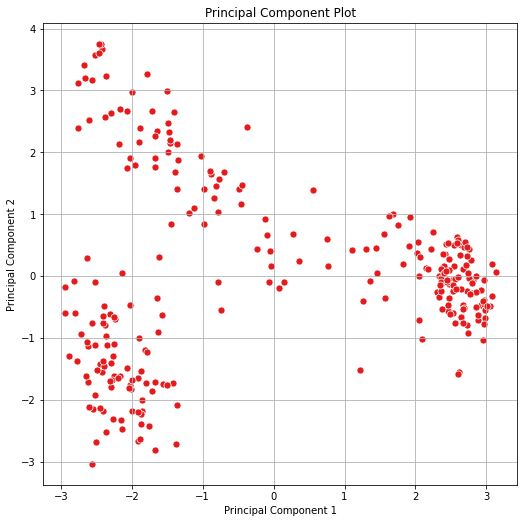

In [ ]:
# Plot the principal component analysis results
pca_plot(tracks_df[audio_feature_cols])

## Today: Classification using $k$-Means Clustering

Our Principal Component Analysis in the first session helped us to visualize the variation of track audio features in just two dimensions. Looking at the scatterplot of the first two principal components above, we can see that there are a few different groups of tracks. But how do we mathematically separate the tracks into these meaningful groups?

One way to separate the tracks into meaningful groups based on similar audio features is to use clustering. Clustering is a machine learning technique that is very powerful for identifying patterns in unlabeled data where the ground truth is not known.

### What is $k$-Means Clustering?

$k$-Means Clustering is one of the most popular clustering algorithms. The algorithm assigns each data point to a cluster using four main steps.

**Step 1: Initialize the Clusters**\
Based on the user's desired number of clusters $k$, the algorithm randomly chooses a centroid for each cluster. In this example, we choose a  $k=3$,  therefore the algorithm randomly picks 3 centroids.

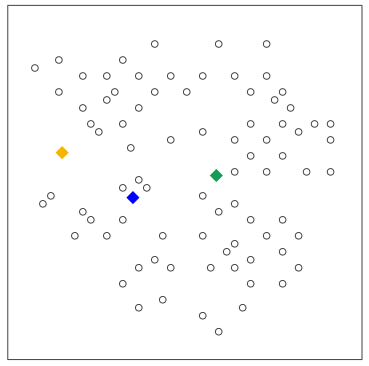

**Step 2: Assign Each Data Point**\
The algorithm assigns each point to the closest centroid to get $k$ initial clusters.

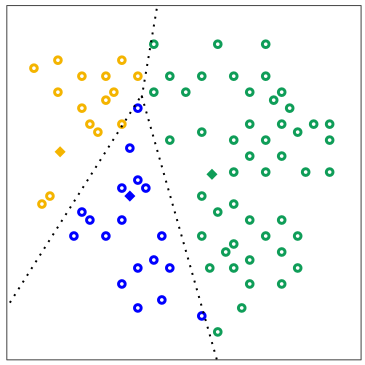

**Step 3: Recompute the Cluster Centers**\
For every cluster, the algorithm recomputes the centroid by taking the average of all points in the cluster. The changes in centroids are shown below by arrows.

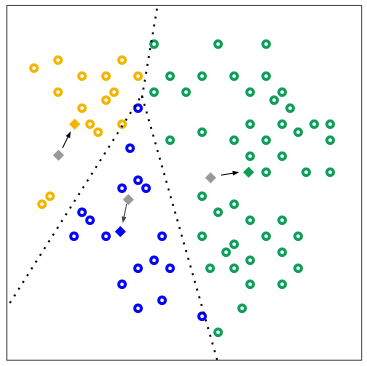

**Step 4: Reassign the Points**\
Since the centroids change, the algorithm then re-assigns the points to the closest centroid. The image below shows the new clusters after re-assignment.

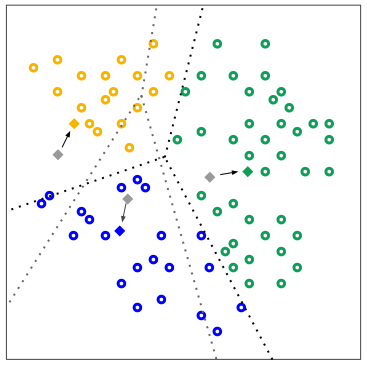


The algorithm repeats the calculation of centroids and assignment of points until points stop changing clusters. When clustering large datasets, you stop the algorithm before reaching convergence, using other criteria instead.

*Note: Some content in this section was [adapted](https://creativecommons.org/licenses/by/4.0/) from Google's free [Clustering in Machine Learning](https://developers.google.com/machine-learning/clustering) course. The course is a great resource if you want to explore clustering in more detail!*

### Cluster the Spotify Tracks using their Audio Features

Now, we will use the `sklearn.cluster.KMeans` Python library to apply the $k$-means algorithm to our `tracks_df` data. Based on our visual inspection of the PCA plot, let's start with a guess k=3 to get 3 clusters.

In [ ]:
initial_k = ____

# Scale the data, so that the units of features don't impact feature importance
scaled_df = StandardScaler().fit_transform(tracks_df[audio_feature_cols])

# Cluster the data using the k means algorithm
initial_cluster_results = ______(n_clusters=initial_k, n_init=25, random_state=rs).fit(scaled_df)

Now, let's print the cluster results. Notice that we're given a number (0 or 1) for each observation in our data set. This number is the id of the cluster assigned to each track.

In [ ]:
# Print the cluster results
print(initial_cluster_results._______)

And let's save the cluster results in our `tracks_df` dataframe as a column named `initial_cluster` so we can access them later.

In [ ]:
# Save the cluster labels in our dataframe
tracks_df[______________] = ['Cluster ' + str(i) for i in __________.______]

Let's plot the PCA plot and color each observation based on the assigned cluster to visualize our $k$-means results.

In [ ]:
# Show a PCA plot of the clusters
pca_plot(tracks_df[audio_feature_cols], classes=tracks_df['initial_cluster'])

Does it look like our $k$-means algorithm correctly separated the tracks into clusters? Does each color map to a distinct group of points?

### How do our clusters of songs differ?

One way we can evaluate our clusters is by looking how the distribution of each data feature varies by cluster. In our case, let's check to see if tracks in the different clusters tend to have different values of energy, loudness, or speechiness.

In [ ]:
# Plot the distribution of audio features by cluster
g = sns.pairplot(tracks_df, hue="initial_cluster",
                 vars=['danceability', 'energy', 'loudness', 'speechiness', 'tempo'],
                 hue_order=sorted(tracks_df.initial_cluster.unique()), palette='Set1')
g.fig.suptitle('Distribution of Audio Features by Cluster', y=1.05)
plt.show()

### Experiment with different values of $k$

Use the slider to select different values of $k$, then run the cell below to see how the choice of the number of clusters affects our results.

In [ ]:
trial_k = 10 #@param {type:"slider", min:1, max:10, step:1}

# Cluster the data using the k means algorithm
trial_cluster_results = KMeans(n_clusters=trial_k, n_init=25, random_state=rs).fit(scaled_df)

# Save the cluster labels in our dataframe
tracks_df['trial_cluster'] = ['Cluster ' + str(i) for i in trial_cluster_results.labels_]

# Show a PCA plot of the clusters
pca_plot(tracks_df[audio_feature_cols], classes=tracks_df['trial_cluster'])

# Plot the distribution of audio features by cluster
g = sns.pairplot(tracks_df, hue="trial_cluster",
                 vars=['danceability', 'energy', 'loudness', 'speechiness', 'tempo'],
                 hue_order=sorted(tracks_df.trial_cluster.unique()), palette='Set1')
g.fig.suptitle('Distribution of Audio Features by Cluster', y=1.05)
plt.show()

### Which value of $k$ works best for our data?

You may have noticed that the $k$-means algorithm requires you to choose $k$ and decide the number of clusters before you run the algorithm. But how do we know which value of $k$ is the best fit for our data?  

One approach is to track the total distance from points to their cluster centroid as we increase the number of clusters, $k$. Usually, the total distance decreases as we increase $k$, but we reach a value of $k$ where increasing $k$ only marginally decreases the total distance. An elbow plot helps us to find that value of $k$; it's the value of $k$ where the slope of the line in the elbow plot crosses the threshold of slope $=-1$. When you plot distance vs $k$, this point often looks like an "elbow".

Let's build an elbow plot to select the value of $k$ that will give us the highest quality clusters that best explain the variation in our data.

In [ ]:
# Calculate the Total Distance for each value of k between 1 and 10
scores = []
k_list = np.arange(____,____)

for i in k_list:
    fit_k = _____(n_clusters=i, n_init=5, random_state=rs).fit(scaled_df)
    scores.append(fit_k.inertia_)

# Plot this in an elbow plot
plt.figure(figsize=(11,8.5))
sns.lineplot(______, ______)
plt.xlabel('Number of clusters $k$')
plt.ylabel('Total Point to Centroid Distance')
plt.grid()
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

Do you see the "elbow"? At what value of $k$ does it occur?

### Evaluate the results of our clustering algorithm for the best $k$

Use the slider below to choose the "best" $k$ that you determined from looking at the elbow plot. Evaluate the results in the PCA plot. Does this look like a good value of $k$ to separate the data into meaningful clusters?

In [ ]:
best_k = 1 #@param {type:"slider", min:1, max:10, step:1}

# Cluster the data using the k means algorithm
best_cluster_results = KMeans(n_clusters=best_k, n_init=25, random_state=rs).fit(scaled_df)

# Save the cluster labels in our dataframe
tracks_df['best_cluster'] = ['Cluster ' + str(i) for i in best_cluster_results.labels_]

# Show a PCA plot of the clusters
pca_plot(tracks_df[audio_feature_cols], classes=tracks_df['best_cluster'])

## How did we do?

In addition to the mathematical ways to validate the selection of the best $k$ parameter for our model and the quality of our resulting clusters, there's another very important way to evaluate our results: listening to the tracks!

Let's listen to the tracks in each cluster! What do you notice about the attributes that tracks in each cluster have in common? What do you notice about how the clusters are different? What makes each cluster unique?

Cluster 0
Track Name: Needy Bees
Artist Name(s): Nick Hakim


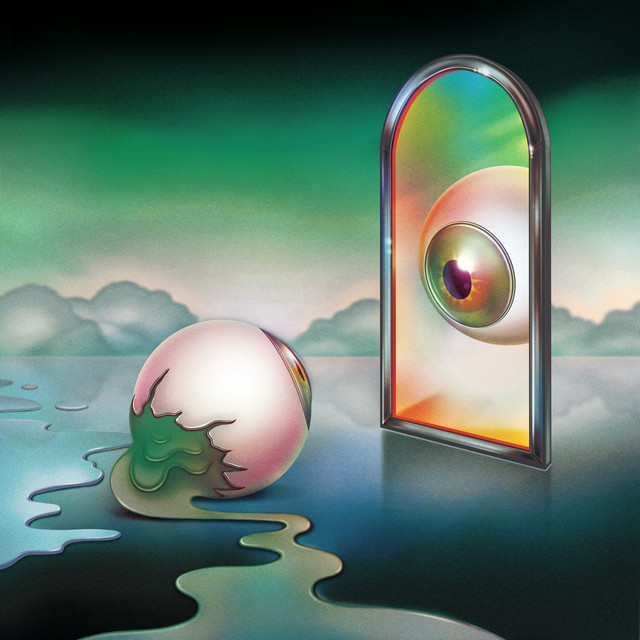

Press <Enter> for the next track or q then <Enter> to quit: 


In [ ]:
play_cluster_tracks(tracks_df, cluster_column='best_cluster')

## Wrap Up and Next Session

That's a wrap! Now that you've learned some practical skills in data science, please join us tomorrow afternoon for the third and final session in our series, where we'll talk about how to continue your studies and/or pursue a career in Data Science!

**Making Your Next Professional Play in Data Science**\
Friday, October 2 | 11:30am - 12:45pm PT\
[https://sched.co/dtqZ](https://sched.co/dtqZ)